In [ ]:
'''
Alex Costanzino, Marco Costante
MSc student in Artificial Intelligence
@ Alma Mater Studiorum, University of Bologna
March, 2021
'''

# **Food recognition challenge**
Recognizing food from images is an extremely useful tool for a variety of use cases. In particular, it would allow people to track their food intake by simply taking a picture of what they consume. Food tracking can be of personal interest, and can often be of medical relevance as well. Medical studies have for some time been interested in the food intake of study participants but had to rely on food frequency questionnaires that are known to be imprecise.

Image-based food recognition has in the past few years made substantial progress thanks to advances in deep learning. But food recognition remains a difficult problem for a variety of reasons.

## Import and parameters

In [ ]:
# Doc: https://segmentation-models.readthedocs.io/
!pip install -U segmentation-models

In [ ]:
%env SM_FRAMEWORK = tf.keras

In [ ]:
import os
import random

import numpy as np
import tensorflow as tf

import keras
import segmentation_models

from tqdm import tqdm
from pycocotools.coco import COCO
import pandas as pd

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [ ]:
''' Upload files from the drive '''
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
'''Image parameters'''
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_CHANNELS = 3

CLASSES = 18 # 16 categories + background + other categories

## Dataset reduction

In [ ]:
'''Loading annotations file for the training set'''
annFile = '/content/drive/MyDrive/deep_learning_project/train/annotations.json'
coco_train = COCO(annFile)

loading annotations into memory...
Done (t=5.34s)
creating index...
index created!


In [ ]:
'''Display COCO categories'''
cats = coco_train.loadCats(coco_train.getCatIds())
nms = [cat['name'] for cat in cats]

print('COCO categories: \n{}\n'.format(' '.join(nms)))

COCO categories: 
water pear egg grapes butter bread-white jam bread-whole-wheat apple tea-green white-coffee-with-caffeine tea-black mixed-salad-chopped-without-sauce cheese tomato-sauce pasta-spaghetti carrot onion beef-cut-into-stripes-only-meat rice-noodles-vermicelli salad-leaf-salad-green bread-grain espresso-with-caffeine banana mixed-vegetables bread-wholemeal savoury-puff-pastry wine-white dried-meat fresh-cheese red-radish hard-cheese ham-raw bread-fruit oil-vinegar-salad-dressing tomato cauliflower potato-gnocchi wine-red sauce-cream pasta-linguini-parpadelle-tagliatelle french-beans almonds dark-chocolate mandarine semi-hard-cheese croissant sushi berries biscuits thickened-cream-35 corn celeriac alfa-sprouts chickpeas leaf-spinach rice chocolate-cookies pineapple tart coffee-with-caffeine focaccia pizza-with-vegetables-baked soup-vegetable bread-toast potatoes-steamed spaetzle frying-sausage lasagne-meat-prepared boisson-au-glucose-50g ma1-4esli peanut-butter chips-french-

In [ ]:
'''Getting all categories with respect to their total images and showing the 16 most frequent categories'''
no_images_per_category = {}

for n, i in enumerate(coco_train.getCatIds()):
    imgIds = coco_train.getImgIds(catIds=i)
    label = nms[n]
    no_images_per_category[label] = len(imgIds)

img_info = pd.DataFrame(coco_train.loadImgs(coco_train.getImgIds()))

'''Most frequent categories'''
categories = pd.DataFrame(no_images_per_category.items()).sort_values(1).iloc[::-1][0][:30].tolist()[0:16]
print(categories)

'''Dict with most frequent categories, the ones we chose'''
category_channels = dict(zip(categories, range(1, len(categories) + 1)))
print(category_channels)

['water', 'bread-white', 'salad-leaf-salad-green', 'tomato', 'butter', 'bread-wholemeal', 'carrot', 'coffee-with-caffeine', 'rice', 'egg', 'mixed-vegetables', 'wine-red', 'apple', 'jam', 'potatoes-steamed', 'banana']
{'water': 1, 'bread-white': 2, 'salad-leaf-salad-green': 3, 'tomato': 4, 'butter': 5, 'bread-wholemeal': 6, 'carrot': 7, 'coffee-with-caffeine': 8, 'rice': 9, 'egg': 10, 'mixed-vegetables': 11, 'wine-red': 12, 'apple': 13, 'jam': 14, 'potatoes-steamed': 15, 'banana': 16}


In [ ]:
'''Extraction of COCO annotations for the selected categories''' 

image_directory = '/content/drive/MyDrive/deep_learning_project/train_reduced/images/'

folder_cats = os.listdir(image_directory)

coco_imgs_train = []

for i, folder in tqdm(enumerate(folder_cats), total = len(folder_cats), position = 0, leave = True):
    if not folder.startswith('.'):
        images_train = os.listdir(image_directory + folder)
    for image_name in images_train:
        imgId = int(coco_train.getImgIds(imgIds = [image_name.split('.')[0]])[0].lstrip("0"))
        coco_imgs_train.append(coco_train.loadImgs([imgId])[0])

TRAINING_SET_SIZE = len(coco_imgs_train)

100%|██████████| 16/16 [00:33<00:00,  2.09s/it]


## Generators

### Training set generator

In [ ]:
'''Creating masks splitted out in channels: each channel corresponds to one category'''

def read_resize_image(coco_img, path):
    
    image = cv2.imread(path + coco_img['file_name'], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))         
    image = np.asarray(image)
    
    return image

def generate_mask(coco_img, coco_annotations):
    annIds = coco_annotations.getAnnIds(imgIds=coco_img['id'], iscrowd = None)
    anns = coco_annotations.loadAnns(annIds)
    mask = np.zeros((coco_img['height'], coco_img['width'], CLASSES), dtype=np.float32)

    # Setting all pixels of the background channel to 1
    mask[:,:,0] = np.ones((coco_img['height'], coco_img['width']), dtype=np.float32)

    for ann in anns:
        catName = [cat['name'] for cat in cats if cat['id'] == ann['category_id']][0]
        if catName in category_channels:
            mask[:,:,category_channels[catName]] = coco_annotations.annToMask(ann)
            mask[:,:,0] -= mask[:,:,category_channels[catName]] 
        else:
            mask[:,:,-1] += coco_annotations.annToMask(ann)

    mask[:,:,0] -= mask[:,:,-1]
    mask[mask < 0] = 0
    mask[mask > 1] = 1
    mask = (cv2.resize(mask, (IMAGE_WIDTH, IMAGE_HEIGHT)))
    
    return mask

def dataset_generator(coco_imgs, path, coco_annotations, cats, category_channels, dataset_size, batch_size):

    batch_features = np.zeros((batch_size, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
    batch_labels = np.zeros((batch_size, IMAGE_WIDTH, IMAGE_HEIGHT, CLASSES), dtype = np.float64)

    c = 0
    random.shuffle(coco_imgs)

    while True:
        for i in range(c, c + batch_size):

            coco_img = coco_imgs[i]

            batch_features[i - c] = read_resize_image(coco_img, path)
            batch_labels[i - c] = generate_mask(coco_img, coco_annotations)

        c = c + batch_size
        if(c + batch_size >= dataset_size):
            c = 0
            random.shuffle(coco_imgs)

        yield (batch_features, batch_labels)

### Validation set generator

In [ ]:
'''Loading annotations file for the validation set'''
annFile = '/content/drive/MyDrive/deep_learning_project/val/annotations.json'
coco_val = COCO(annFile)

loading annotations into memory...
Done (t=0.76s)
creating index...
index created!


In [ ]:
'''Extraction of COCO annotations for the selected categories in the validation set'''

image_directory = '/content/drive/MyDrive/deep_learning_project/val/images/'

images_val = os.listdir(image_directory)

coco_imgs_val = []

for i, image in tqdm(enumerate(images_val), total = len(images_val), position = 0, leave = True):
        
    imgId = int(coco_val.getImgIds(imgIds = [image.split('.')[0]])[0].lstrip("0"))
    coco_img_val = coco_val.loadImgs([imgId])[0]
    annIds = coco_val.getAnnIds(imgIds=coco_img_val['id'], iscrowd = None)
    anns = coco_val.loadAnns(annIds)

    for ann in anns:
        catName = [cat['name'] for cat in cats if cat['id'] == ann['category_id']][0]
        if catName in category_channels.keys():
            coco_imgs_val.append(coco_val.loadImgs([imgId])[0])
            break

VALIDATION_SET_SIZE = len(coco_imgs_val)

100%|██████████| 1269/1269 [00:00<00:00, 17663.42it/s]


## Generator test
Do not run before generator call. It's just a test!

In [ ]:
''' Generator test: call an entire batch of the generator '''
gen_t = next(gen_val)
image_t = gen_t[0] # Image
mask_t = gen_t[1] # Mask

In [ ]:
'''Shape check'''
print(image_t.shape, mask_t.shape)

In [ ]:
''' Image check '''
plt.imshow(image_t[3].astype(np.uint8))
plt.show()

In [ ]:
''' Mask check '''
for i in range(CLASSES):
  plt.imshow(mask_t[3,:,:,i])
  plt.show()

In [ ]:
''' Type check '''
print(type(mask_t[0,0,0,0]))
print(np.max(mask_t[:,:,:,:]))

print(type(image_t[0,0,0,0]))
print(image_t[0,:,:,0])

## Neural network structure

In [ ]:
''' U-net parameters'''
FILTER = 16

### Input layer 

In [ ]:
''' Input layer '''
inputs = tf.keras.layers.Input((IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs) # Normalization

### Contractive path

In [ ]:
''' Contractive path '''
### Layer 1
c1 = tf.keras.layers.Conv2D(FILTER, (3, 3),
                            kernel_initializer = 'he_normal',
                            padding = 'same')(s)

c1 = tf.keras.layers.BatchNormalization()(c1) # Batch normalization instead of dropout (note: I had to split the conv2D and ReLU)

c1 = tf.keras.layers.Activation('selu')(c1) 

c1 = tf.keras.layers.Conv2D(FILTER, (3, 3),
                            activation = 'selu',
                            kernel_initializer = 'he_normal',
                            padding = 'same')(c1)

p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

### Layer 2
c2 = tf.keras.layers.Conv2D(FILTER*2, (3, 3),
                            kernel_initializer = 'he_normal',
                            padding = 'same')(p1)

c2 = tf.keras.layers.BatchNormalization()(c2) # Batch normalization instead of dropout (note: I had to split the conv2D and ReLU)

c2 = tf.keras.layers.Activation('selu')(c2)

c2 = tf.keras.layers.Conv2D(FILTER*2, (3, 3),
                            activation = 'selu',
                            kernel_initializer = 'he_normal',
                            padding = 'same')(c2)

p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

### Layer 3
c3 = tf.keras.layers.Conv2D(FILTER*4, (3, 3),
                            kernel_initializer = 'he_normal',
                            padding = 'same')(p2)

c3 = tf.keras.layers.BatchNormalization()(c3) # Batch normalization instead of dropout (note: I had to split the conv2D and ReLU)

c3 = tf.keras.layers.Activation('selu')(c3)

c3 = tf.keras.layers.Conv2D(FILTER*4, (3, 3),
                            activation = 'selu',
                            kernel_initializer = 'he_normal',
                            padding = 'same')(c3)

p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

### Layer 4
c4 = tf.keras.layers.Conv2D(FILTER*8, (3, 3),
                            kernel_initializer = 'he_normal',
                            padding = 'same')(p3)

c4 = tf.keras.layers.BatchNormalization()(c4) # Batch normalization instead of dropout (note: I had to split the conv2D and ReLU)

c4 = tf.keras.layers.Activation('selu')(c4)

c4 = tf.keras.layers.Conv2D(FILTER*8, (3, 3),
                            activation = 'selu',
                            kernel_initializer = 'he_normal',
                            padding = 'same')(c4)

p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

### Layer 5
c5 = tf.keras.layers.Conv2D(FILTER*16, (3, 3),
                            kernel_initializer = 'he_normal',
                            padding = 'same')(p4)

c5 = tf.keras.layers.BatchNormalization()(c5) # Batch normalization instead of dropout (note: I had to split the conv2D and ReLU)

c5 = tf.keras.layers.Activation('selu')(c5)

c5 = tf.keras.layers.Conv2D(FILTER*16, (3, 3),
                            activation = 'selu',
                            kernel_initializer = 'he_normal',
                            padding = 'same')(c5)

### Expansive path

In [ ]:
''' Expansive path '''
# Layer 6
u6 = tf.keras.layers.Conv2DTranspose(FILTER*8, (2, 2),
                                     strides = (2, 2),
                                     padding = 'same')(c5)

u6 = tf.keras.layers.concatenate([u6, c4])

c6 = tf.keras.layers.Conv2D(FILTER*8, (3, 3),
                            kernel_initializer = 'he_normal',
                            padding = 'same')(u6)

c6 = tf.keras.layers.BatchNormalization()(c6) # Batch normalization instead of dropout (note: I had to split the conv2D and ReLU)

c6 = tf.keras.layers.Activation('selu')(c6)

c6 = tf.keras.layers.Conv2D(FILTER*8, (3, 3),
                            activation = 'selu',
                            kernel_initializer = 'he_normal',
                            padding = 'same')(c6)

# Layer 7
u7 = tf.keras.layers.Conv2DTranspose(FILTER*4, (2, 2),
                                     strides = (2, 2),
                                     padding = 'same')(c6)

u7 = tf.keras.layers.concatenate([u7, c3])

c7 = tf.keras.layers.Conv2D(FILTER*4, (3, 3),
                            kernel_initializer = 'he_normal',
                            padding = 'same')(u7)

c7 = tf.keras.layers.BatchNormalization()(c7) # Batch normalization instead of dropout (note: I had to split the conv2D and ReLU)

c7 = tf.keras.layers.Activation('selu')(c7)

c7 = tf.keras.layers.Conv2D(FILTER*4, (3, 3),
                            activation = 'selu',
                            kernel_initializer = 'he_normal',
                            padding = 'same')(c7)

# Layer 8
u8 = tf.keras.layers.Conv2DTranspose(FILTER*2, (2, 2),
                                     strides = (2, 2),
                                     padding = 'same')(c7)

u8 = tf.keras.layers.concatenate([u8, c2])

c8 = tf.keras.layers.Conv2D(FILTER*2, (3, 3),
                            kernel_initializer = 'he_normal',
                            padding = 'same')(u8)

c8 = tf.keras.layers.BatchNormalization()(c8) # Batch normalization instead of dropout (note: I had to split the conv2D and ReLU)

c8 = tf.keras.layers.Activation('selu')(c8)

c8 = tf.keras.layers.Conv2D(FILTER*2, (3, 3),
                            activation = 'selu',
                            kernel_initializer = 'he_normal',
                            padding = 'same')(c8)

# Layer 9
u9 = tf.keras.layers.Conv2DTranspose(FILTER, (2, 2),
                                     strides = (2, 2),
                                     padding = 'same')(c8)

u9 = tf.keras.layers.concatenate([u9, c1], axis = 3)

c9 = tf.keras.layers.Conv2D(FILTER, (3, 3),
                            kernel_initializer = 'he_normal',
                            padding = 'same')(u9)

c9 = tf.keras.layers.BatchNormalization()(c9) # Batch normalization instead of dropout (note: I had to split the conv2D and ReLU)

c9 = tf.keras.layers.Activation('selu')(c9) # Dropout

c9 = tf.keras.layers.Conv2D(FILTER, (3, 3),
                            activation = 'selu',
                            kernel_initializer = 'he_normal',
                            padding = 'same')(c9)

### Output layer

In [ ]:
''' Output layer '''
outputs = tf.keras.layers.Conv2D(CLASSES, (1, 1), activation = 'softmax')(c9)

In [ ]:
''' Model building '''
model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
______________________________________________________________________________________________

## Loss functions and metrics

### Smoothed Jaccard distance loss

In [ ]:
def jaccard_distance(y_true, y_pred, smooth = 100):
    """ Calculates mean of Jaccard distance as a loss function """
    intersection = tf.reduce_sum(y_true * y_pred, axis = -1)
    union = tf.reduce_sum(y_true + y_pred, axis = -1)

    jac = (intersection + smooth) / (union - intersection + smooth)
    jd =  (1 - jac) * smooth
    
    return tf.reduce_mean(jd)

In [ ]:
''' Metrics '''
IoU_metric = segmentation_models.metrics.IOUScore()

F_metric = segmentation_models.metrics.FScore()

''' Losses '''
crossentropy_loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.5, name = 'categorical_crossentropy')

jaccard_loss = segmentation_models.losses.JaccardLoss()

dice_loss = segmentation_models.losses.DiceLoss() 

focal_loss = segmentation_models.losses.CategoricalFocalLoss() # Non ha righe ma la IoU rimane bassa

# Dice + Focal loss
combined_loss = dice_loss + (1 * focal_loss)

## Model

### Checkpoints

In [ ]:
''' Model checkpoints: the model will be saved at each epoch, if there is an improvement '''
checkpointer = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/deep_learning_project/trained_models/modella-128-16-smoothing_jaccard.h5',
                                                  monitor = 'loss', # Select which quantity to refers, can also use metrics or the validation 
                                                  verbose = 1,
                                                  save_best_only = False, 
                                                  mode = 'auto', 
                                                  save_freq = 'epoch' # Flag to save at each epoch
                                                  )

### Neural network training


In [ ]:
  ''' Generator initialization '''
path_train = '/content/drive/MyDrive/deep_learning_project/train/images/'
path_val = '/content/drive/MyDrive/deep_learning_project/val/images/'

BATCH_SIZE = 64

gen_train = dataset_generator(coco_imgs = coco_imgs_train, 
                              path = path_train, 
                              coco_annotations = coco_train, 
                              cats = cats, 
                              category_channels = category_channels, 
                              dataset_size = TRAINING_SET_SIZE, 
                              batch_size = BATCH_SIZE)

gen_val = dataset_generator(coco_imgs = coco_imgs_val, 
                            path = path_val, 
                            coco_annotations = coco_val, 
                            cats = cats, 
                            category_channels = category_channels, 
                            dataset_size = VALIDATION_SET_SIZE, 
                            batch_size = BATCH_SIZE) 

In [ ]:
''' Load previous model: after the first training upload the previous configuration and use it as initial state for new training'''
model = tf.keras.models.load_model('/content/drive/MyDrive/deep_learning_project/trained_models/modella-128-16-smoothing_jaccard.h5',
                                     custom_objects = {'jaccard_distance_loss': jaccard_distance_loss}) # Remember to select the right custom objects (losses, metrics)
model.summary()

In [ ]:
''' Learning rate scheduler '''
initial_learning_rate = 1.25e-4

lr_schedule1 = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                                                             decay_steps = 100000,
                                                             decay_rate = 0.96,
                                                             staircase = True)

lr_schedule2 = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate, 
                                                        decay_steps = 1000, 
                                                        alpha = 0.15)

In [ ]:
''' Before starting a new traning is it possible to change optimizer or loss functions'''
opt = tf.keras.optimizers.Adam(learning_rate = lr_schedule1, 
                               beta_1 = 0.9, 
                               beta_2 = 0.999, 
                               epsilon = 1e-07, 
                               amsgrad = True,
                               clipnorm = 1.0)

opt2 = tf.keras.optimizers.SGD(learning_rate = lr_schedule2,
                               momentum = 0.99,
                               nesterov = True,
                               clipnorm = 1.0)

model.compile(optimizer = opt, 
              loss = [jaccard_distance_loss], 
              metrics = 'accuracy')

In [ ]:
''' Model training '''
EPOCHS = 20

records = model.fit(gen_train,
                    validation_data = gen_val,
                    steps_per_epoch = np.ceil(TRAINING_SET_SIZE / BATCH_SIZE),
                    validation_steps = np.ceil(VALIDATION_SET_SIZE / BATCH_SIZE),
                    epochs = EPOCHS, 
                    verbose = 1,
                    callbacks = [checkpointer]
                    )

## Evaluation
For a known ground truth mask A, you propose a mask B, then we first compute IoU (Intersection Over Union).

IoU measures the overall overlap between the true region and the proposed region. Then we consider it a **true detection** when there is at least half an overlap, namely when IoU > 0.5

Then we can define the following parameters :
* Precision (IoU > 0.5);
* Recall (IoU > 0.5).

The final scoring parameters: 
* AP{IoU > 0.5};  
* AR{IoU > 0.5};

are computed by averaging over all the precision and recall values for all known annotations in the ground truth.

Guide 1: https://www.jeremyjordan.me/evaluating-image-segmentation-models/

Guide 2: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

In [ ]:
'''Generator initialization'''
path_val = "/content/drive/MyDrive/deep_learning_project/val/images/"

gen_val = dataset_generator(coco_imgs = coco_imgs_val, 
                            path = path_val, 
                            coco_annotations = coco_val, 
                            cats = cats, 
                            category_channels = category_channels, 
                            dataset_size = VALIDATION_SET_SIZE, 
                            batch_size = VALIDATION_SET_SIZE) 

model = tf.keras.models.load_model('/content/drive/MyDrive/deep_learning_project/trained_models/modella-128-16-focal_loss.h5',
                                   custom_objects = {'focal_loss': focal_loss, 'iou_score': IoU_metric})

In [ ]:
validation_set = next(gen_val)
images_val_set = validation_set[0] # Images
masks_val_set = validation_set[1]  # Masks

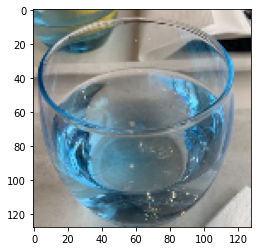

In [ ]:
plt.imshow(images_val_set[4].astype(np.uint8))
plt.show()

In [ ]:
predictions = model.predict(images_val_set, verbose = 1)

18/18 [==============================] - 23s 1s/step


In [ ]:
def show_masks_threshold(prediction):
  labels = list(category_channels.keys())
  labels.insert(0, "background")
  labels.append("other")

  prediction_threshold = prediction.copy()
  prediction_threshold[prediction_threshold >= 0.4] = 1.
  prediction_threshold[prediction_threshold < 0.4] = 0.

  for i in range(CLASSES):
    if np.max(prediction_threshold[:,:,i]) != 0:
      plt.imshow(prediction_threshold[:,:,i])
      plt.title(labels[i])
      plt.show()

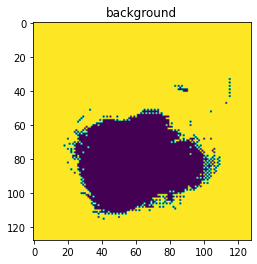

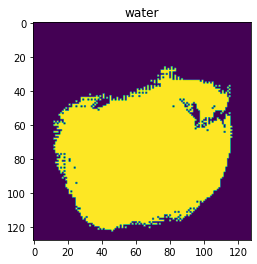

In [ ]:
'''Showing the predicted masks'''
show_masks_threshold(predictions[4,:,:,:])

In [ ]:
def show_mask_overlapping(prediction):
  labels = list(category_channels.keys())
  labels.insert(0, "background")
  labels.append("other")

  prediction_threshold = prediction.copy()
  prediction_threshold[prediction_threshold >= 0.4] = 1.
  prediction_threshold[prediction_threshold < 0.4] = 0.

  mask_plot = np.zeros((IMAGE_WIDTH, IMAGE_HEIGHT), dtype = np.float32)

  '''Preparing the mask with overlapping'''
  for i in range(CLASSES):
    prediction_threshold[:,:,i] = prediction_threshold[:,:,i] * i
    mask_plot += prediction_threshold[:,:,i]
    mask_plot[mask_plot >= i] = i

  values = np.array(np.unique(mask_plot), dtype=np.uint8)
  plt.figure(figsize=(8,4))
  im = plt.imshow(mask_plot, interpolation='none')
  colors = [ im.cmap(im.norm(value)) for value in range(len(labels))]
  patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in values ]
  plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

  plt.axis('off')
  plt.show()

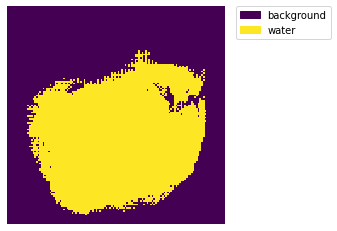

In [ ]:
show_mask_overlapping(predictions[4,:,:,:])

In [ ]:
'''Computing the IoU, Recall and Precision metrics'''
def compute_results(mean_iou, recall, precision, mask, prediction):
    mean_iou.update_state(mask, prediction)
    recall.update_state(mask, prediction)
    precision.update_state(mask, prediction)

    return recall.result().numpy(), precision.result().numpy(), mean_iou.result().numpy()

mean_iou = tf.keras.metrics.MeanIoU(num_classes = 17)
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()

mean_iou_results = []
recall_results = []
precision_results = []

threshold = 0.5

for i in range(VALIDATION_SET_SIZE):
    mask = masks_val_set[i,:,:,:-1]
    prediction = predictions[i,:,:,:-1]

    recall_res, precision_res, mean_iou_res = compute_results(mean_iou, recall, precision, mask, prediction)

    mean_iou_results.append(mean_iou_res)
    mean_iou.reset_states()

    if mean_iou_res >= threshold:

        precision_results.append(precision_res)
        precision.reset_states()

        recall_results.append(recall_res)
        recall.reset_states()

print('Mean precision: {}.'.format(np.average(precision_results)))
print('Mean recall: {}.'.format(np.average(recall_results)))
print('Calculated on {} samples, over {} total samples, that passed the IoU test.'.format(len(np.asarray(mean_iou_results)[np.asarray(mean_iou_results) >= threshold]), VALIDATION_SET_SIZE))
print(mean_iou_results)

Mean precision: 0.7332707047462463.
Mean recall: 0.7217566967010498.
Calculated on 562 samples, over 563 total samples, that passed the IoU test.
[0.7323706, 0.6715261, 0.6783299, 0.7961718, 0.84053713, 0.69943917, 0.5744072, 0.6211286, 0.74094975, 0.69050616, 0.67104775, 0.73799336, 0.68074274, 0.7273712, 0.6893473, 0.88507986, 0.6353746, 0.6097515, 0.7262223, 0.5781711, 0.6721324, 0.58172095, 0.58508456, 0.62525856, 0.609282, 0.72509396, 0.5691719, 0.5486752, 0.6823301, 0.7935508, 0.7491808, 0.6800419, 0.84214985, 0.68856853, 0.6169679, 0.7944895, 0.7569312, 0.6057102, 0.5495276, 0.59870017, 0.63235974, 0.5469092, 0.6771592, 0.7756554, 0.5714301, 0.6102357, 0.58283114, 0.5455448, 0.6980732, 0.7396338, 0.7538418, 0.72434443, 0.66792613, 0.8100069, 0.63837814, 0.66628736, 0.60978615, 0.8336755, 0.68753386, 0.6462046, 0.68100804, 0.78784466, 0.7256592, 0.67293787, 0.5497679, 0.5823641, 0.67023146, 0.5962027, 0.6519557, 0.81395423, 0.5886351, 0.7082677, 0.7075278, 0.62184906, 0.59948367,

In [ ]:
print(np.max(mean_iou_results), np.min(mean_iou_results))

0.91958785 0.49278224


In [ ]:
print(np.mean(mean_iou_results))

0.67396533
